Start this on the zedboard first
```bash
$ sudo python3 litex_server.py --devmem --devmem-offset 0x40000000
```

In [520]:
%pylab notebook
from struct import pack, unpack
from time import sleep
import sys
sys.path.append("../..")
from common import *
from scope_app import autoBitslip, autoIdelay, getSamples

Populating the interactive namespace from numpy and matplotlib


# Setup SPI, reset and dump LTC2175 registers

In [521]:
r = conLitexServer('../build/csr.csv')
print("f_sample:", r.regs.lvds_f_sample_value.read() / 1e6, "MHz")

ltc_spi = LTC_SPI(r)
for i in range(5):
    print("{:2x}: {:02x}".format(i, ltc_spi.get_ltc_reg(i)))

ltc_spi.set_ltc_reg(0, 0x80)   # Software reset
# ltc_spi.set_ltc_reg(1, 0x10)   # Sleep mode
# ltc_spi.set_ltc_reg(1, 0x00)   # Waky waky

ltc_spi.setTp(1)
autoBitslip(r)
autoIdelay(r)

Connected to Port 1234
LTC2175 demonstrator 2019-10-22 19:54:03
f_sample: 125.000628 MHz
 0: 00
 1: 20
 2: 00
 3: 00
 4: 01
autoBitslip(): aligned after 0
autoIdelay(): min = 6, mean = 12, max = 19 idelays


# Play with bitslip / idelay parameters

### show status

In [522]:
def print_frm():
    idel = r.regs.lvds_idelay_value.read()
    v = r.regs.lvds_frame_peek.read()
    print("ID: {:}  F: {:08b}".format(idel, v))
    for i in range(4):
        v = getattr(r.regs, 'lvds_data_peek{:}'.format(i)).read()
        print("{:}: {:016b}".format(i, v))
ltc_spi.setTp(1)
print_frm()

ID: 12  F: 11110000
0: 0000000000000001
1: 0000000000000001
2: 0000000000000001
3: 0000000000000001


### bitslip until we get 0xF0 on frame_peek

In [ ]:
r.regs.lvds_bitslip_csr.write(1)
print_frm()

### IDELAY adjustments to find the eye limits

In [ ]:
r.regs.lvds_idelay_inc.write(1)
print_frm()

In [ ]:
r.regs.lvds_idelay_dec.write(1)
print_frm()

do a bitslip until we get 0x0F

### map data lanes
Check that each bit in the test-pattern end up in the right place in the output word

In [195]:
for ch in range(4):
    print("Channel {:d}".format(ch))
    for i in range(14):
        tpValue = 1 << i
        ltc_spi.setTp(tpValue)
        rVal = getattr(r.regs, 'lvds_data_peek{:d}'.format(ch)).read()
        print("{:016b} {:016b}".format(tpValue, rVal))    

Channel 0
0000000000000001 0000000000000001
0000000000000010 0000000000000010
0000000000000100 0000000000000100
0000000000001000 0000000000001000
0000000000010000 0000000000010000
0000000000100000 0000000000100000
0000000001000000 0000000001000000
0000000010000000 0000000010000000
0000000100000000 0000000100000000
0000001000000000 0000001000000000
0000010000000000 0000010000000000
0000100000000000 0000100000000000
0001000000000000 0001000000000000
0010000000000000 0010000000000000
Channel 1
0000000000000001 0000000000000001
0000000000000010 0000000000000010
0000000000000100 0000000000000100
0000000000001000 0000000000001000
0000000000010000 0000000000010000
0000000000100000 0000000000100000
0000000001000000 0000000001000000
0000000010000000 0000000010000000
0000000100000000 0000000100000000
0000001000000000 0000001000000000
0000010000000000 0000010000000000
0000100000000000 0000100000000000
0001000000000000 0001000000000000
0010000000000000 0010000000000000
Channel 2
0000000000000001 0

# Read ADC sample

In [523]:
ltc_spi.set_ltc_reg(3, 0)   # Test pattern off
ltc_spi.set_ltc_reg(1, (1 << 5))   # Randomizer off, twos complement output

In [422]:
# Lowest 2 bits are always zero in 16 bit LVDS mode
# 12 bit ADC, so next 2 bits are also zero
rVal = r.regs.lvds_data_peek0.read()
print("0x{0:04x} 0b{0:016b}".format(rVal))
# Decode offset binary mode
print(twos_comp(rVal, 14))

0x2b9c 0b0010101110011100
-5220


# Read randomized ADC sample

In [ ]:
ltc_spi.set_ltc_reg(1, (1<<6))   # Randomizer on

In [ ]:
rVal = r.regs.lvds_data_peek.read() >> 4
print("0x{0:03x} 0b{0:012b}".format(rVal))
# XOR LSB with any other bit
if rVal & 0x01:
    rVal ^= 0xFFE
# Decode offset binary mode
print(rVal - (1 << 11))

# Read acquisition memory

In [200]:
hd(r.big_read(0x10000000, 0x400), 2, 1)


0000: 005c 01dc 0358 04d4 0648 07b8 0924 0a8c 
0008: 0bf0 0d48 0e98 0fdc 111c 124c 1374 1490 
0010: 15a0 1694 1788 186c 1934 19fc 1ab0 1b4c 
0018: 1bd0 1c50 1cb4 1d0c 1d50 1d84 1d9c 1da4 
0020: 1da4 1d84 1d54 1d10 1cc0 1c54 1bdc 1b54 
0028: 1ab4 1a04 1948 1878 1798 16a8 15a8 149c 
0030: 138c 1264 1130 0ff8 0ea8 0d60 0c00 0aa8 
0038: 0940 07d4 0664 04e8 036c 01f8 0074 3efc 
0040: 3d80 3c04 3a8c 3914 37a8 363c 34d8 337c 
0048: 3224 30e4 2fa0 2e64 2d3c 2c20 2b08 2a08 
0050: 2918 2830 2758 268c 25d8 2538 24a0 2420 
0058: 23ac 2350 2300 22d0 22a8 2294 2298 22a8 
0060: 22d0 2308 2354 23b4 2428 24a4 253c 25e0 
0068: 2694 275c 2830 2918 2a08 2b10 2c18 2d34 
0070: 2e68 2f90 30d0 321c 3370 34cc 3630 3798 
0078: 3904 3a78 3be8 3d70 3ee0 0060 01e0 0360 
0080: 04cc 0648 07b8 0928 0a90 0bf4 0d44 0e94 
0088: 0fdc 1120 1248 1370 1490 159c 1698 1788 
0090: 1864 1934 19f8 1ab0 1b48 1bd4 1c50 1cbc 
0098: 1d0c 1d50 1d80 1d9c 1dac 1d9c 1d84 1d54 
00a0: 1d14 1cc0 1c54 1be0 1b50 1ab8 1a08 1944 
00a8: 1870 1

In [524]:
r.regs.acq_trig_level.write(0)
print(hex(r.regs.acq_trig_level.read()))
r.regs.acq_trig_csr.write(1)

0x0


<IPython.core.display.Javascript object>


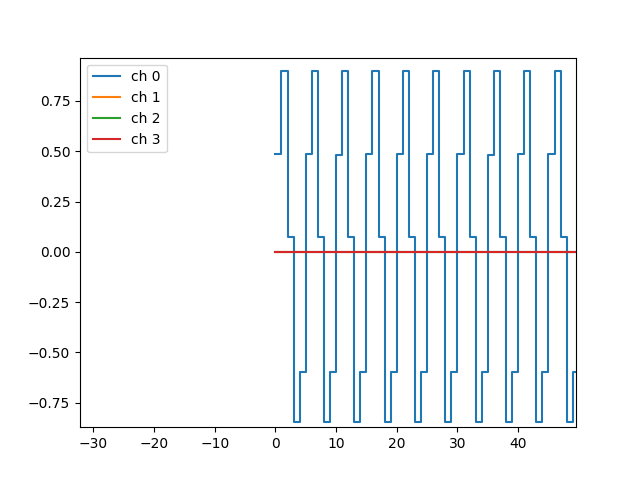

In [525]:
close('all')
for i in range(4):
#     dat = array(r.big_read(0x10000000 + i * 0x01000000, 0x1000))
#     dat = twos_comps(dat >> 2, 14)
    dat = getSamples(r, i, 0x1000)
    plot(dat, label='ch ' + str(i), drawstyle='steps-post')
legend()

In [526]:
r.regs.ctrl_bus_errors.read()

0

# Vector volt-meter

In [527]:
ftw = int(25.04e6 / 125e6 * 2**32)
r.regs.vvm_ddc_ftw.write(ftw)
r.regs.vvm_ddc_deci.write(48)
print('f_sample', r.regs.lvds_f_sample_value.read())
print('ddc_deci', r.regs.vvm_ddc_deci.read())
print('ddc_ftw', hex(r.regs.vvm_ddc_ftw.read()))

f_sample 125000628
ddc_deci 48
ddc_ftw 0x33482be8


In [583]:
for i in range(4):
    print(getattr(r.regs, "vvm_mag{}".format(i)).read() / (2 << 19))
print()
for i in range(4):
    print(getattr(r.regs, "vvm_phase{}".format(i)).read() / (2 << 20))

0.4437122344970703
0.41169071197509766
0.41169071197509766
0.0

0.0
0.02745199203491211
0.48769426345825195
0.3049039840698242


# Demonstrate bit - mapping ...
of serdes lane bits to ADC sample words

In [148]:
N_CHANNELS = 4
S = 8
D = N_CHANNELS * 2 + 1
data_outs = [arange(i * S, (i + 1) * S) for i in range(D)]
for i, d in enumerate(data_outs):
    print("lane", i, "bit", d)
print()
for i in range(N_CHANNELS):
    print("channel", i, myzip(data_outs[2 * i + 1], data_outs[2 * i])[2:])

lane 0 bit [0 1 2 3 4 5 6 7]
lane 1 bit [ 8  9 10 11 12 13 14 15]
lane 2 bit [16 17 18 19 20 21 22 23]
lane 3 bit [24 25 26 27 28 29 30 31]
lane 4 bit [32 33 34 35 36 37 38 39]
lane 5 bit [40 41 42 43 44 45 46 47]
lane 6 bit [48 49 50 51 52 53 54 55]
lane 7 bit [56 57 58 59 60 61 62 63]
lane 8 bit [64 65 66 67 68 69 70 71]

channel 0 [9, 1, 10, 2, 11, 3, 12, 4, 13, 5, 14, 6, 15, 7]
channel 1 [25, 17, 26, 18, 27, 19, 28, 20, 29, 21, 30, 22, 31, 23]
channel 2 [41, 33, 42, 34, 43, 35, 44, 36, 45, 37, 46, 38, 47, 39]
channel 3 [57, 49, 58, 50, 59, 51, 60, 52, 61, 53, 62, 54, 63, 55]


In [516]:
l = [1, 2, 3]

In [518]:
l + ['a', 'b']

[1, 2, 3, 'a', 'b']

In [519]:
l

[1, 2, 3]